In [1]:
import os
import shutil
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from matplotlib.lines import Line2D

In [2]:
data_path = "/home/shared/data_raw/LAC/data_collection_1"

i = 100
image = Image.open(os.path.join(data_path, "front_left", f"{i}.png")).convert("RGB")

# Huggingface


In [3]:
from transformers import pipeline

/home/guillemc/miniconda3/envs/lac/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
semantic_segmentation = pipeline(
    "image-segmentation", "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"
)
results = semantic_segmentation(image)
results

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': None,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'sidewalk',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'fence',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'pole',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'truck',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'motorcycle',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': None,
  'label': 'bicycle',
  'mask': <PIL.Image.Image image mode=L size=1280x720>}]

# Language Segment Anything

https://github.com/luca-medeiros/lang-segment-anything


In [5]:
from lang_sam import LangSAM

In [6]:
model = LangSAM()

Could not load the custom kernel for multi-scale deformable attention: CUDA_HOME environment variable is not set. Please set it to your CUDA install root.
Could not load the custom kernel for multi-scale deformable attention: /home/guillemc/.cache/torch_extensions/py310_cu121/MultiScaleDeformableAttention/MultiScaleDeformableAttention.so: cannot open shared object file: No such file or directory
Could not load the custom kernel for multi-scale deformable attention: /home/guillemc/.cache/torch_extensions/py310_cu121/MultiScaleDeformableAttention/MultiScaleDeformableAttention.so: cannot open shared object file: No such file or directory
Could not load the custom kernel for multi-scale deformable attention: /home/guillemc/.cache/torch_extensions/py310_cu121/MultiScaleDeformableAttention/MultiScaleDeformableAttention.so: cannot open shared object file: No such file or directory
Could not load the custom kernel for multi-scale deformable attention: /home/guillemc/.cache/torch_extensions/py3

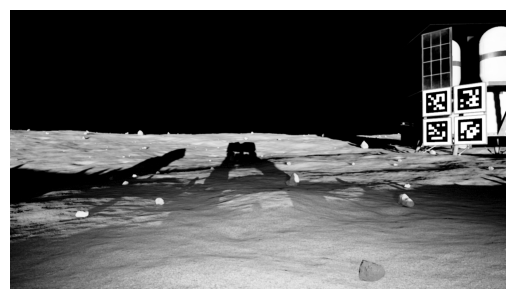

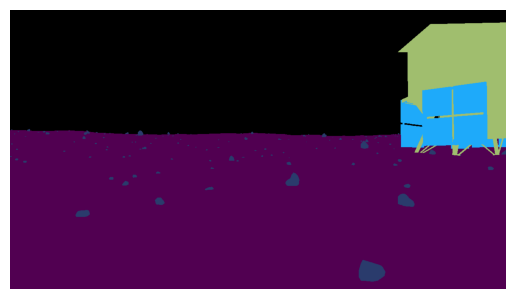

In [40]:
base_path = Path("/home/shared")
scene = "data_collection_1"
camera = "front_left"
scene_path = base_path / "data_raw" / "LAC" / scene
images_rgb_path = scene_path / "front_left"
images_sem_path = scene_path / "front_left_semantic"
image_rgb_path = images_rgb_path / "34.png"
image_sem_path = images_sem_path / "34.png"
image_rgb = cv2.imread(image_rgb_path.as_posix(), cv2.IMREAD_COLOR)
image_sem = cv2.imread(image_sem_path.as_posix(), cv2.IMREAD_COLOR)
plt.imshow(image_rgb)
plt.axis("off")
plt.show()
plt.imshow(image_sem)
plt.axis("off")
plt.show()

array([[  0,   0,   0],
       [ 30, 170, 250],
       [ 42,  59, 108],
       [ 81,   0,  81],
       [160, 190, 110]], dtype=uint8)


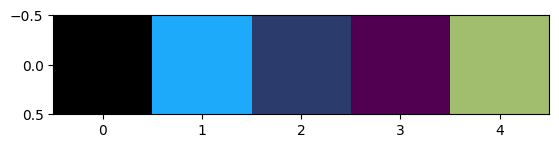

In [41]:
colors_unique = np.unique(np.vstack(image_sem), axis=0)
print(repr(colors_unique))
plt.imshow([colors_unique / 255.0])

In [10]:
semantic_data = [
    ("Fiducials", "fiducials", np.array([30, 170, 250])),
    ("Rocks", "rocks", np.array([42, 59, 108])),
    ("Lander", "white vehicle", np.array([160, 190, 110])),
    ("Shadow", "dark shadow", np.array([150, 40, 60])),
    ("Sun", "sun", np.array([255, 255, 0])),
    ("Ground", "ground", np.array([81, 0, 81])),
    ("Sky", "sky", np.array([0, 0, 0])),
    ("Unknown", "unknown", np.array([255, 255, 255])),
]
prompt2color = {prompt: color for _, prompt, color in semantic_data}
prompt2label = {prompt: label for label, prompt, _ in semantic_data}

In [11]:
prompt = ".".join([prompt for label, prompt, color in semantic_data])
image_pil = Image.fromarray(image_rgb.copy())
results = model.predict([image_pil], [prompt])
res = results[0]
print(res["labels"])

Predicting 1 masks
Predicted 1 masks
['ground', 'sky', 'rocks', 'rocks', 'dark shadow', 'rocks', 'rocks', 'rocks', 'rocks', 'white vehicle', 'fiducials']


/home/guillemc/miniconda3/envs/lac/lib/python3.10/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [12]:
res["masks"].shape

(11, 720, 1280)

In [13]:
[prompt for prompt in res["labels"]]

['ground',
 'sky',
 'rocks',
 'rocks',
 'dark shadow',
 'rocks',
 'rocks',
 'rocks',
 'rocks',
 'white vehicle',
 'fiducials']

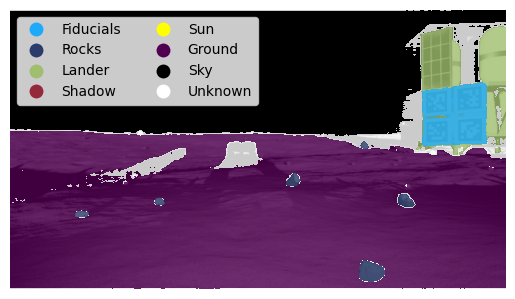

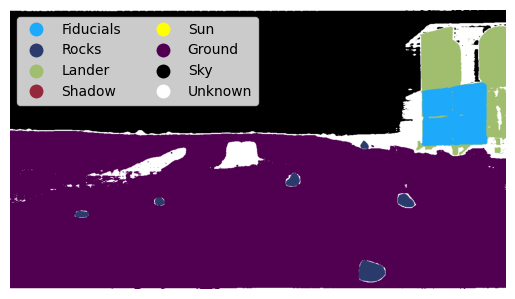

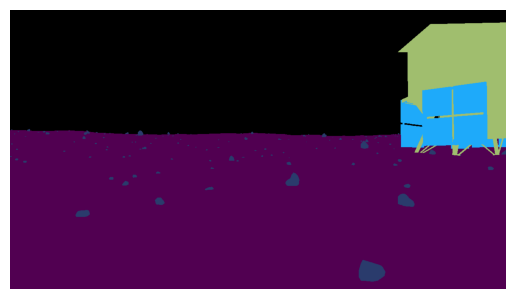

In [15]:
plt.imshow(image_pil)

image_proc = np.ones_like(image_rgb) * prompt2color["unknown"] / 255

unknown_mask = np.zeros(image_rgb.shape[:2], dtype=float)
res_dict = {
    prompt: [res["masks"][i] for i in range(len(res["labels"])) if res["labels"][i] == prompt]
    for prompt in prompt2color.keys()
}

for label, prompt, color in semantic_data[::-1]:
    if label == "Shadow":
        continue
    for mask in res_dict[prompt]:
        mask_rgb = np.zeros((*mask.shape, 4))  # RGBA format
        mask_rgb[..., :3] = color / 255  # Assign RGB color
        mask_rgb[..., 3] = mask * 0.8  # Alpha channel (transparency)
        image_proc[mask.astype(bool)] = color / 255
        unknown_mask += mask
        plt.imshow(mask_rgb, interpolation="none")

unknown_rgb = np.zeros((*image_rgb.shape[:2], 4))  # RGBA format
unknown_rgb[..., :3] = prompt2color["unknown"] / 255  # Assign RGB color
unknown_rgb[..., 3] = (unknown_mask == 0) * 0.8
plt.imshow(unknown_rgb, interpolation="none")

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        label=label,
        markerfacecolor=color / 255,
        markersize=10,
        linestyle="None",
        markeredgewidth=0,
    )
    for label, _, color in semantic_data
]


plt.legend(handles=legend_elements, loc="upper left", ncol=2)
plt.axis("off")
plt.show()

plt.imshow(image_proc)
plt.legend(handles=legend_elements, loc="upper left", ncol=2)
plt.axis("off")
plt.show()

plt.imshow(image_sem)
plt.axis("off")
plt.show()

In [16]:
np.unique(image_proc.reshape(-1, image_proc.shape[2]), axis=0) * 255

array([[  0.,   0.,   0.],
       [ 30., 170., 250.],
       [ 42.,  59., 108.],
       [ 81.,   0.,  81.],
       [160., 190., 110.],
       [255., 255., 255.]])

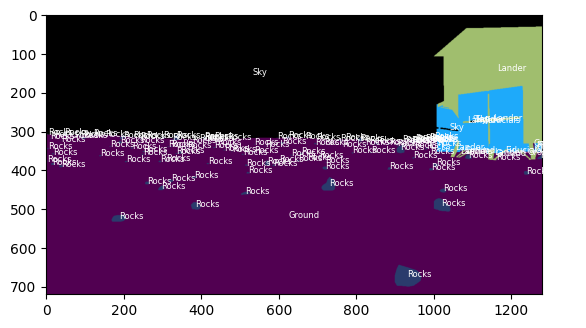

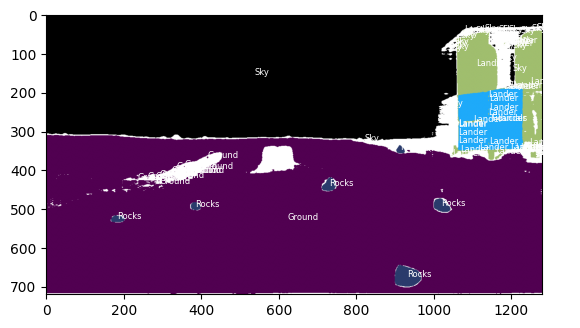

In [17]:
from scipy import ndimage


def plot_semantic_labels(image):
    plt.imshow(image)

    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)

    # Process each unique color
    for label, _, color in semantic_data:
        # Create a binary mask for the current color
        mask = np.all(image == color, axis=-1).astype(np.uint8)
        mask |= np.all(image * 255 == color, axis=-1).astype(np.uint8)

        # Find connected components
        labeled_array, num_features = ndimage.label(mask)

        # Compute centroids of the connected components
        centroids = ndimage.center_of_mass(mask, labeled_array, range(1, num_features + 1))

        # Plot centroids and label them with the color
        if label not in ("Unknown"):
            for centroid in centroids:
                y, x = int(centroid[0]), int(centroid[1])  # Convert to integer
                plt.text(
                    x,
                    y,
                    label,
                    color="white",
                    fontsize=6,
                    bbox=dict(facecolor="black", edgecolor="none", alpha=0),
                )

    # Show the result
    plt.show()


plot_semantic_labels(image_sem)
plot_semantic_labels(image_proc)

In [ ]:
import time

tic = time.time()
n = 10
for i in range(n):
    image_rgb_path = images_rgb_path / f"{34+i}.png"
    image_rgb = cv2.imread(image_rgb_path.as_posix())
    image_pil = Image.fromarray(image_rgb.copy())
    model.predict([image_pil], [prompt])
toc = time.time()
print((toc - tic) / n, "s/image")

Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
0.11603937149047852 s/image


# UNet

In [ ]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import to_tensor, resize
import segmentation_models_pytorch as smp
from PIL import Image

# Paths
data_path = '/your/basepath'
img_dir = os.path.join(data_path, 'front_left')
mask_dir = os.path.join(data_path, 'front_left_semantic')

# Semantic mapping
semantic_colors = {
    (250, 170, 30): 0,   # Fiducials
    (108, 59, 42): 1,    # Rocks
    (110, 190, 160): 2,  # Lander
    (81, 0, 81): 3,      # Ground
    (0, 0, 0): 4,        # Sky
}

def rgb_to_class(mask_rgb):
    mask_np = np.array(mask_rgb)
    class_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
    for rgb, idx in semantic_colors.items():
        matches = np.all(mask_np == rgb, axis=-1)
        class_mask[matches] = idx
    return class_mask

# Dataset
class SegDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname)

        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        mask_bgr = cv2.imread(mask_path)
        mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)

        img_tensor = to_tensor(resize(Image.fromarray(img_rgb), (256, 256)))
        mask_class = rgb_to_class(mask_rgb)
        mask_tensor = torch.from_numpy(np.array(resize(Image.fromarray(mask_class), (256, 256), Image.NEAREST))).long()

        return img_tensor, mask_tensor

# File list
all_filenames = [f"{i}.png" for i in range(34, 1794)]
np.random.seed(42)
np.random.shuffle(all_filenames)

# Split
split_idx = int(0.8 * len(all_filenames))
train_files = all_filenames[:split_idx]
test_files = all_filenames[split_idx:]

train_ds = SegDataset(train_files)
test_ds = SegDataset(test_files)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=1)

# Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=5,
).to(device)

# Loss & Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
model.train()
for epoch in range(5):  # adjust epochs
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

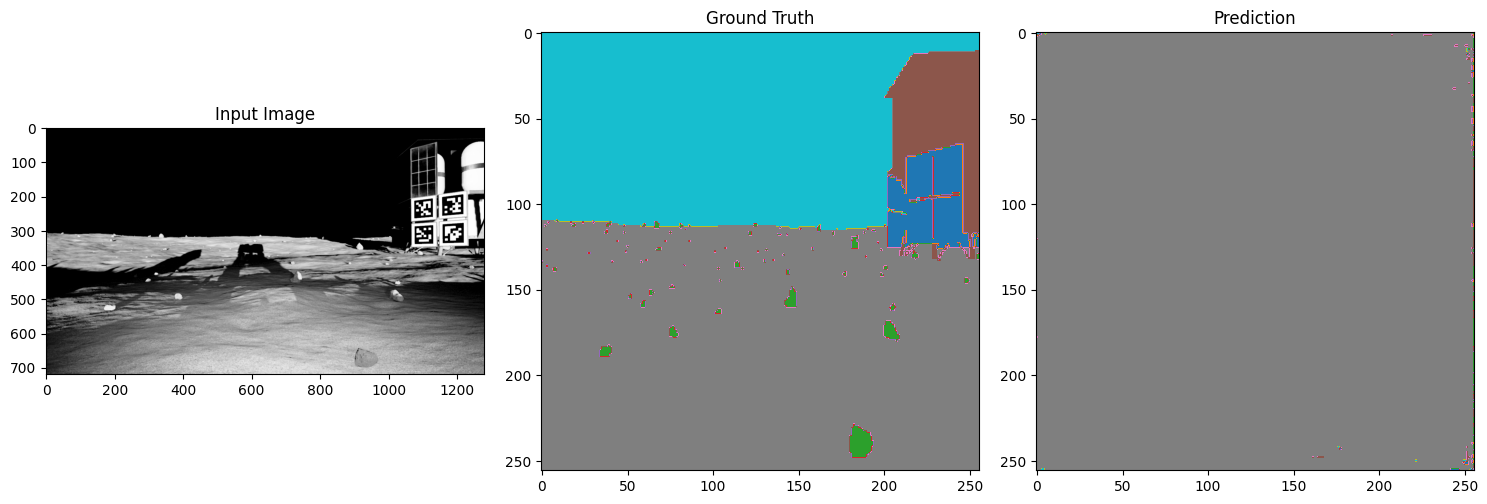

In [39]:
import os
import numpy as np
import cv2
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_tensor, resize
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from PIL import Image

# Path setup
image_path = os.path.join(data_path, 'front_left', '34.png')
mask_path = os.path.join(data_path, 'front_left_semantic', '34.png')

# Semantic label mapping
semantic_colors = {
    (30, 170, 250): 0,   # Fiducials
    (42, 59, 108): 1,    # Rocks
    (160, 190, 110): 2,  # Lander
    (81, 0, 81): 3,      # Ground
    (0, 0, 0): 4,        # Sky
}

def rgb_to_class(mask_rgb):
    mask_np = np.array(mask_rgb)
    class_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
    for rgb, idx in semantic_colors.items():
        matches = np.all(mask_np == rgb[::-1], axis=-1)
        class_mask[matches] = idx
    return class_mask

# Load image and mask using OpenCV
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_bgr = cv2.imread(mask_path)
mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)

# Transform and preprocessing
image_tensor = to_tensor(resize(Image.fromarray(image_rgb), (256, 256))).unsqueeze(0)
mask_class = rgb_to_class(mask_rgb)
mask_class_resized = resize(Image.fromarray(mask_class), (256, 256), interpolation=Image.NEAREST)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=5,
)
model.to(device)
model.eval()

# Inference
with torch.no_grad():
    output = model(image_tensor.to(device))
    pred = output.argmax(1).squeeze().cpu()

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(mask_class_resized, cmap='tab10', vmin=0, vmax=4)
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='tab10', vmin=0, vmax=4)
plt.title("Prediction")

plt.tight_layout()
plt.show()

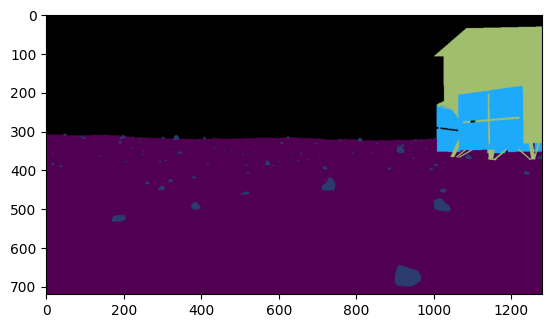

In [ ]:
plt.imshow(cv2.imread(mask_path))

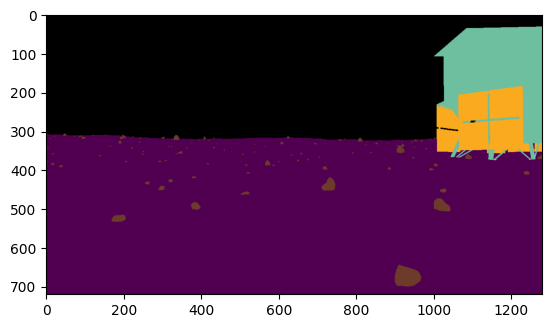

In [20]:
plt.imshow(Image.open(mask_path))

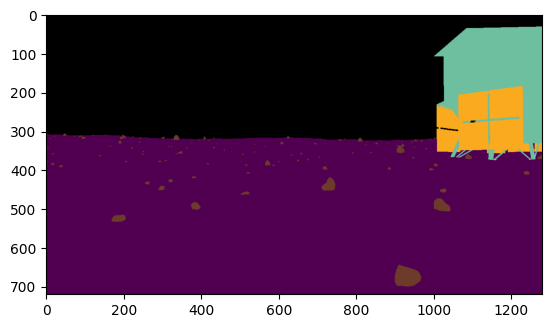

In [5]:
plt.imshow(mask_rgb)